In [1]:
from astropy.io import ascii
from astropy.io import fits
from astropy.table import Table
import matplotlib.pyplot as plt
import re
import numpy as np
import copy

In [22]:
def getData(folder, filename): #I'm finally using python properly
    rdr = ascii.get_reader(Reader=ascii.Basic)
    rdr.header.splitter.delimiter = ' '
    rdr.data.splitter.delimiter = ' '
    if folder == 'DES_BLINDnoHOSTZ':
        rdr.header.start_line = 12
        rdr.data.start_line = 13
    else:
        rdr.header.start_line = 14
        rdr.data.start_line = 15
    rdr.data.end_line = None
    
    t = rdr.read('%s/%s' % (folder, filename))
    FLT = t['FLT']
    MJD = t['MJD']
    IMJD = copy.deepcopy(MJD)
    for i in range(len(IMJD)):
        IMJD[i] = int(IMJD[i])
    UIMJD, indices = np.unique(IMJD, return_index=True)
    
    obs_length = MJD[-1]-MJD[0]
    
    ts = np.zeros((50, 9))
        
    for i in range(len(indices)):
        start = indices[i]
        if i+1 < len(indices):
            end = indices[i+1]
        else: 
            end = len(MJD)
        TMJD = 0
        count = 0
        for j in range(start,end): 
            error = t['FLUXCALERR'][j]
            if error >= 0:
                flux = t['FLUXCAL'][j]
                TMJD += t['MJD'][j]
                count += 1
                if FLT[j] =='g':
                    ts[i,1] = flux
                    ts[i,5] = error
                elif FLT[j] =='r':
                    ts[i,2] = flux
                    ts[i,6] = error
                elif FLT[j] =='i':
                    ts[i,3] = flux
                    ts[i,7] = error
                else:  # FLT[j] =='z'
                    ts[i,4] = flux
                    ts[i,8] = error

        if TMJD != 0:
            ts[i,0] = TMJD/count

    offset = ts[0,0]
    for i in range(len(indices)):
        if ts[i,0] != 0: ts[i,0] -= offset
    
    return (ts,obs_length, len(indices))

In [23]:
def getInfo(info, file):
    for line in file:
        if line.startswith('%s' % info):
            return line[(len(info)+2)::] #might have extra spaces in front and it's a string
    return None

In [24]:
#choose which folder to work with
folder= 'DES_BLINDnoHOSTZ'

In [25]:
if folder == 'DES_BLINDnoHOSTZ':
    colName = 'DES_SN000018.DAT'
    totalNum = 18347
    infoL = ['SURVEY','SNID', 'SNTYPE', 'FILTERS', 'RA', 'DECL', 'FAKE', 'MWEBV', 'REDSHIFT_SPE','NOBS', 'NVAR']
else:
    colName = 'DES_SN000041.DAT'
    totalNum = 18320
    infoL = ['SURVEY','SNID','SNTYPE','FILTERS','RA','DECL','FAKE','MWEBV','REDSHIFT_SPE','HOST_GALAXY_GALID','HOST_GALAXY_PHOTO-Z','NOBS','NVAR']

list = ascii.read('%s/%s.LIST' % (folder, folder), data_start = 0)

#Set up space to gather information
table = dict()
for i in infoL:
    table[i] = []
table['FILENAME'] = []
table['DATA'] = []
table['obs_length'] = []
table['num_data_points'] = []
max_obs_len = 0

for i in range(totalNum):
    with open(folder + '/' + list[colName][i]) as f:
        table['FILENAME'] += [list[colName][i]]
        (ts,obs_length,num__data_points) = getData(folder, list[colName][i])
        if obs_length >= max_obs_len: max_obs_len = obs_length
        table['DATA'] += [ts]
        table['obs_length'] += [obs_length]
        table['num_data_points'] += [num__data_points]
        for j in infoL:
            table[j] += [getInfo(j, f)]

#Normalize observation length and MJDs so they are all between 0-1

for i in range(totalNum):
    for j in range(50):
        table['DATA'][i][j][0] /= max_obs_len

infoList = [table['FILENAME']]
for i in infoL:
    infoList += [table[i]]
infoList += [table['DATA']]
infoList += [table['obs_length']]
infoList += [table['num_data_points']]

In [26]:
output = Table(infoList, names = ['FILENAME']+infoL+['DATA']+['obs_length']+['num_data_points'])

In [27]:
g_m = output['DATA'][:,:,1].flatten() != 0
g_std = np.std(output['DATA'][:,:,1].flatten()[g_m])
g_mean = np.mean(output['DATA'][:,:,1].flatten()[g_m])

r_m = output['DATA'][:,:,2].flatten() != 0
r_std = np.std(output['DATA'][:,:,2].flatten()[r_m])
r_mean = np.mean(output['DATA'][:,:,2].flatten()[r_m])

i_m = output['DATA'][:,:,3].flatten() != 0
i_std = np.std(output['DATA'][:,:,3].flatten()[i_m])
i_mean = np.mean(output['DATA'][:,:,3].flatten()[i_m])

z_m = output['DATA'][:,:,4].flatten() != 0
z_std = np.std(output['DATA'][:,:,4].flatten()[z_m])
z_mean = np.mean(output['DATA'][:,:,4].flatten()[z_m])

output['DATA'][:,:,1][output['DATA'][:,:,1]!=0] -= g_mean
output['DATA'][:,:,1] /= g_std
output['DATA'][:,:,5] /= g_std

output['DATA'][:,:,2][output['DATA'][:,:,2]!=0] -= r_mean
output['DATA'][:,:,2] /= r_std
output['DATA'][:,:,6] /= r_std

output['DATA'][:,:,3][[output['DATA'][:,:,3]!=0]] -= i_mean
output['DATA'][:,:,3] /= i_std
output['DATA'][:,:,7] /= i_std

output['DATA'][:,:,4][[output['DATA'][:,:,4]!=0]] -= z_mean
output['DATA'][:,:,4] /= z_std
output['DATA'][:,:,8] /= z_std

In [28]:
x = np.array(output['FILENAME'])
np.where(x == 'DES_SN155300.DAT')

(array([14291]),)

9


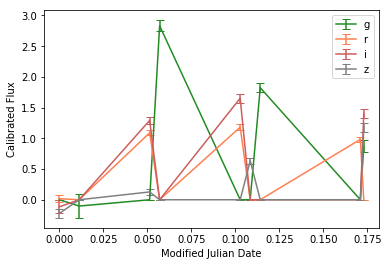

In [29]:
a = 1
num = output['num_data_points'][a]
MJD = output['DATA'][a,:num,0]
print(num)

g_FLUXCAL = output['DATA'][a,:num,1]
r_FLUXCAL = output['DATA'][a,:num,2]
i_FLUXCAL = output['DATA'][a,:num,3]
z_FLUXCAL = output['DATA'][a,:num,4]

g_err = output['DATA'][a,:num,5]
r_err = output['DATA'][a,:num,6]
i_err = output['DATA'][a,:num,7]
z_err = output['DATA'][a,:num,8]

plt.errorbar(MJD, g_FLUXCAL, g_err, capsize = 4, label='g',color = 'forestgreen') 
plt.errorbar(MJD, r_FLUXCAL, r_err, capsize = 4, label='r',color = 'coral')
plt.errorbar(MJD, i_FLUXCAL, i_err, capsize = 4, label='i', color = 'indianred')
plt.errorbar(MJD, z_FLUXCAL, z_err, capsize = 4, label='z', color = 'gray')
plt.xlabel('Modified Julian Date')
plt.ylabel('Calibrated Flux')

plt.legend()
plt.show()

In [30]:
#output.write('normalized_good.fits')

In [31]:
#output.write('normalized_ahh.fits')

In [32]:
output.write('normalized_zero.fits') #when normalizing, keep the zeros zero and don't touch them